# Synthetic Data Generation

We will use a pre-tuned model to produce data. The model output should be a 3D array with condition, signaling node and time point for dimensions. The model output will be sub-sampled to produce the synthetic dataset.

In [2]:
import torch
import numpy
import bionetwork
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

## Run the pre-trained model

Run pre-trained model to produce synthetic data that are going to be used to evaluate the toy model. We will store both `fullYfull` which is the Y for all model states as well as the `X` that we used.

In [3]:
# Setup Parameters
N = 200
inputAmplitude = 3
projectionAmplitude = 1.2
seed = 123
torch.manual_seed(seed)
numpy.random.seed(seed)

# Load network
networkList, nodeNames, modeOfAction = bionetwork.loadNetwork('data/KEGGnet-Model.tsv')
annotation = pandas.read_csv('data/KEGGnet-Annotation.tsv', sep='\t')
bionetParams = bionetwork.trainingParameters(iterations = 150, clipping=1, leak=0.01)

inName = annotation.loc[annotation['ligand'],'code'].values
outName = annotation.loc[annotation['TF'],'code'].values
inName = numpy.intersect1d(nodeNames, inName)
outName = numpy.intersect1d(nodeNames, outName)

parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams)
parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

# Generate data
X = torch.zeros(N, len(inName), dtype=torch.double)
for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
    X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
    X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)

Y, YfullRef, fullYFull = parameterizedModel(X)
fullYFull = fullYFull.detach()

Prepare `X` and `fullYFull` FOR sub-sampling. `X` should be a matrix with Condition as index and Targeted genes as columns. `fullYFull` should be matrix with Condition and Gene as indexes and Time points as columns.

In [4]:
X = X.numpy()
X = pandas.DataFrame(X)
X.index.name = 'Condition'
X.columns = inName
display(X.head())

,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Condition,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.650735,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.000000,0.096139,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.480224,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.000000,0.000000,0.55586,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.11751,0.0,0.0
4,0.000000,0.000000,0.00000,0.874302,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [5]:
fullYFull_np = fullYFull.numpy()
print(fullYFull.shape)  # dimensions: conditions, node names, states

dim1, dim2, dim3 = fullYFull_np.shape

reshaped_array = fullYFull_np.reshape(dim1 * dim2, dim3)

synthetic_data = pandas.DataFrame(reshaped_array)

index = pandas.MultiIndex.from_product([range(dim1), nodeNames], names=['Condition', 'Signaling Node'])
synthetic_data.index = index

display(synthetic_data.head())

torch.Size([200, 409, 150])


0             1             2         3    \
Condition Signaling Node                                                       
0         O00206         -5.585427e-05 -5.743208e-05 -5.724134e-05 -0.000056   
          O14492          2.172743e-02  2.082521e-02  2.082522e-02  0.020825   
          O14511          1.147115e-02  1.147115e-02  1.147115e-02  0.011471   
          O14640         -3.048172e-04 -3.077264e-04 -3.062161e-04 -0.000306   
          O14727          5.414221e-07  5.544846e-07  5.544872e-07  0.000001   

                               4         5         6         7         8    \
Condition Signaling Node                                                     
0         O00206         -0.000015 -0.000015 -0.000015 -0.000015 -0.000015   
          O14492          0.020825  0.020825  0.020825  0.020825  0.020825   
          O14511          0.011471  0.011471  0.011471  0.011471  0.011471   
          O14640         -0.000306 -0.000306 -0.000306 -0.000306 -0.000306   
          O14727          0.000001  0.000001  0.000002  0.000001  0.000002   

                               9    ...       140       141       142  \
Condition Signaling Node            ...                                 
0         O00206         -0.000015  ... -0.000015 -0.000015 -0.000015   
          O14492          0.020825  ...  0.020825  0.020825  0.020825   
          O14511          0.011471  ...  0.011471  0.011471  0.011471   
          O14640         -0.000306  ... -0.000306 -0.000306 -0.000306   
          O14727          0.000002  ...  0.000001  0.000001  0.000001   

                               143       144       145       146       147  \
Condition Signaling Node                                                     
0         O00206         -0.000015 -0.000015 -0.000015 -0.000015 -0.000015   
          O14492          0.020825  0.020825  0.020825  0.020825  0.020825   
          O14511          0.011471  0.011471  0.011471  0.011471  0.011471   
          O14640         -0.000306 -0.000306 -0.000306 -0.000306 -0.000306   
          O14727          0.000001  0.000001  0.000001  0.000001  0.000001   

                               148       149  
Condition Signaling Node                      
0         O00206         -0.000015 -0.000015  
          O14492          0.020825  0.020825  
          O14511          0.011471  0.011471  
          O14640         -0.000306 -0.000306  
          O14727          0.000001  0.000001  

[5 rows x 150 columns]

## Sub-sample synthetic data

Sub-sample `fullYFull` by keeping only the # most variant Conditions and the first 24 Time points with step 3. Select the same Conditions for `X`.

In [31]:
n_conditions = 30
n_timepoints = 24
time_step = 3

synthetic_data_filtered = synthetic_data.iloc[:, :n_timepoints:time_step]

# Calculate the standard deviation for each condition to keep the ones with the heighest
variation = synthetic_data_filtered.groupby('Condition').std().mean(axis=1)
top_conditions = variation.nlargest(n_conditions).index
synthetic_data_filtered = synthetic_data_filtered.loc[top_conditions]

display(synthetic_data_filtered.head())

0         3         6         9   \
Condition Signaling Node                                               
47        O00206         -5.585427e-05 -0.000056 -0.000015 -0.000015   
          O14492          2.172743e-02  0.020825  0.020825  0.020825   
          O14511          1.147115e-02  0.011471  0.011471  0.011471   
          O14640         -3.048172e-04 -0.000306 -0.000306 -0.000306   
          O14727          5.414221e-07  0.000001  0.000002  0.000002   

                                12        15        18        21  
Condition Signaling Node                                          
47        O00206         -0.000015 -0.000015 -0.000015 -0.000015  
          O14492          0.020825  0.020825  0.020825  0.020825  
          O14511          0.011471  0.011471  0.011471  0.011471  
          O14640         -0.000306 -0.000306 -0.000306 -0.000306  
          O14727          0.000002  0.000002  0.000002  0.000002

In [32]:
unique_conditions = synthetic_data_filtered.index.get_level_values('Condition').unique()
unique_conditions

Index([ 47,  72, 122,  15, 164,  41,  35,  26,  49, 197, 123,  96, 127,  34,
       135, 133,  94, 105,   4, 175,  88, 136,  45,  61, 128, 132,  27,  32,
        58,  99],
      dtype='int64', name='Condition')

In [33]:
# Select the same Conditions for X
X_filtered = X.loc[unique_conditions]

### Plot Dynamics to Evaluate Sub-sampling

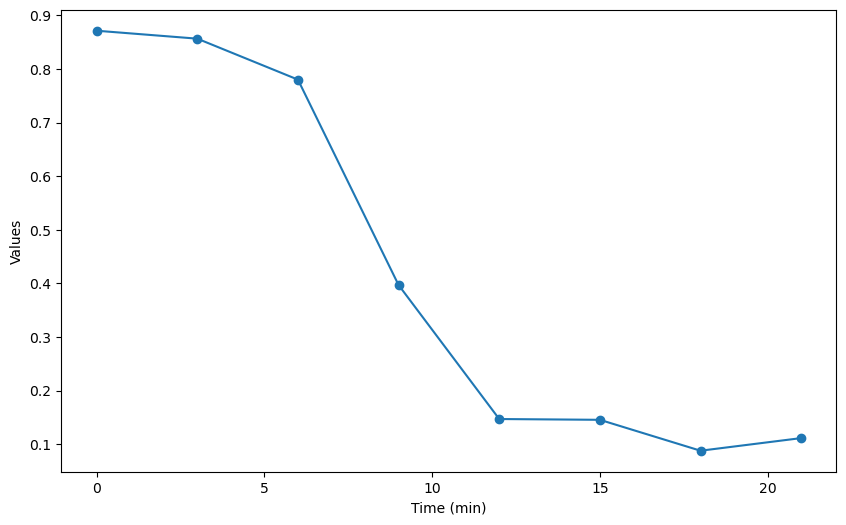

In [34]:
# Select a specific row (Condition, Signaling Node)
specific_row = synthetic_data_filtered.loc[(175, nodeNames[260])]

plt.figure(figsize=(10, 6))
plt.plot(specific_row.index, specific_row.values, marker='o')
plt.xlabel('Time (min)')
plt.ylabel('Values')
plt.show()

c:\Users\kanto\anaconda3\envs\timeseries_phosphoproteome_env\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1000x600 with 0 Axes>

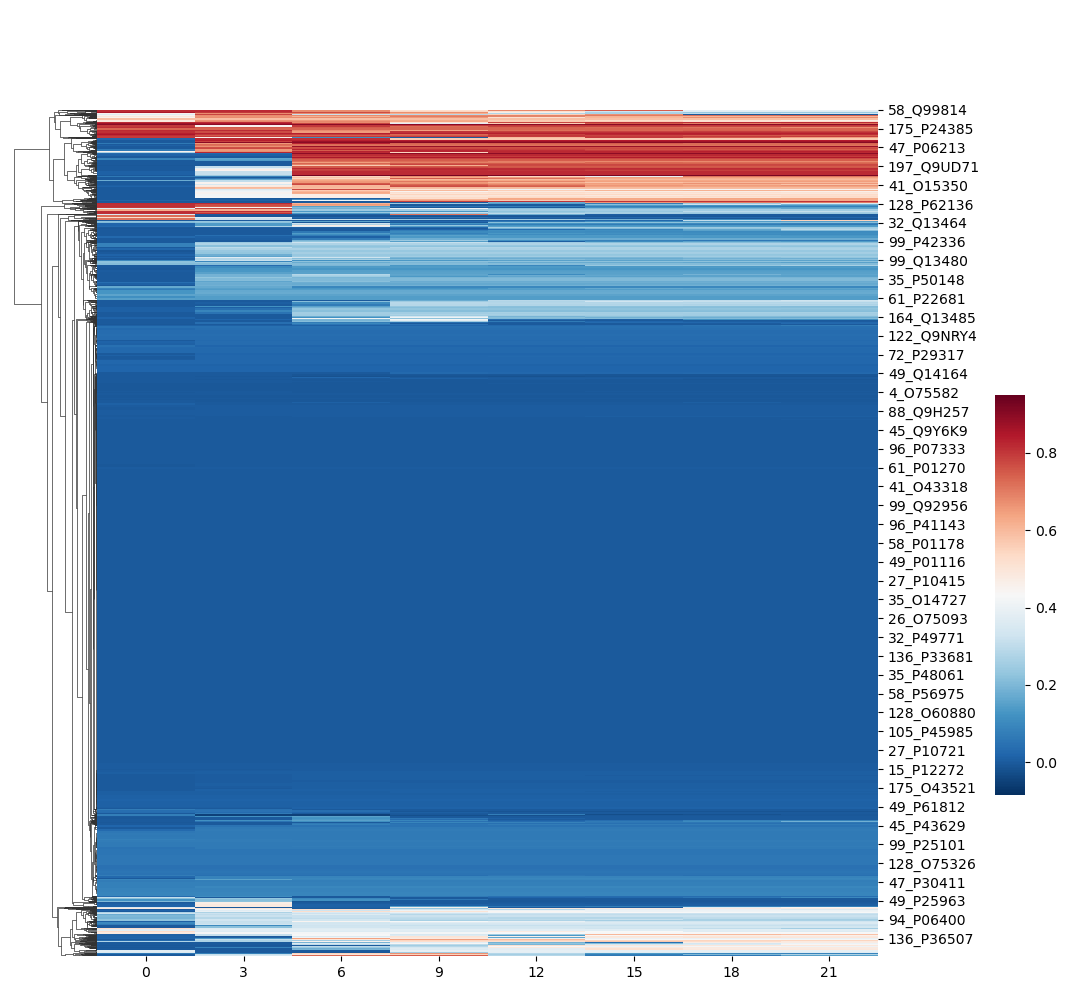

In [38]:
synthetic_data_plot = synthetic_data_filtered.copy()
synthetic_data_plot.index = [f"{cond}_{node}" for cond, node in synthetic_data_plot.index]
plt.figure(figsize=(10, 6))
sns.clustermap(synthetic_data_plot, cmap="RdBu_r", annot=False, col_cluster=False, dendrogram_ratio=0.1, cbar_pos=(1, .2, .03, .4))
plt.show()

## Process Data to be Exported

Reformat `fullYFull` in order to have common Condition_Time index and Genes as columns. Also, store mapping dataset (Condition_Time -> Time point), so we can track which Condition_Time maps to which Y time point when calculating the loss for the toy-model. Add the same Condition_Time to X by expanding it.

In [10]:
synthetic_data_melted = synthetic_data_filtered.reset_index().melt(id_vars=['Condition', 'Signaling Node'], var_name='Time point', value_name='Value')
synthetic_data_melted['Condition_Time'] = synthetic_data_melted['Condition'].astype(str) + '_' + synthetic_data_melted['Time point'].astype(str)
synthetic_data_pivoted = synthetic_data_melted.pivot(index='Condition_Time', columns='Signaling Node', values='Value')
synthetic_data_final = synthetic_data_melted[['Condition_Time', 'Time point']].drop_duplicates().set_index('Condition_Time')
synthetic_data_final = synthetic_data_final.merge(synthetic_data_pivoted, left_index=True, right_index=True)

# Create a new mapping-dataset with Condition_Time and Time point
condition_time_df = synthetic_data_final[['Time point']].reset_index()

synthetic_data_final.drop(columns=['Time point'], inplace=True)  # Delete Time point column from the synthetic dataset

display(condition_time_df)
display(synthetic_data_final)

,Condition_Time,Time point
0,47_0,0
1,72_0,0
2,122_0,0
3,15_0,0
4,164_0,0
...,...,...
395,113_21,21
396,154_21,21
397,22_21,21
398,64_21,21


,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Condition_Time,,,,,,,,,,,,,,,,,,,,,
47_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
72_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
122_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
15_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
164_0,-0.000056,0.021727,0.011471,-0.000305,5.414221e-07,-0.002145,-0.000230,-0.000018,-0.004929,0.009005,...,-0.002311,0.077535,-0.000521,0.191727,0.050499,-0.000382,0.025692,-0.001756,-0.000147,0.059051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113_21,-0.000015,0.020825,0.011471,-0.000306,1.525141e-06,-0.000880,-0.000232,-0.000018,-0.004883,0.009005,...,-0.001915,0.068687,0.169270,0.264516,0.050199,-0.000866,0.402912,-0.005081,-0.000151,0.059037
154_21,-0.000015,0.020825,0.011471,0.774452,1.247932e-06,-0.002136,-0.000232,-0.000018,-0.005034,0.009005,...,-0.000081,0.070125,0.765627,0.297926,0.690725,-0.003091,0.133224,-0.002853,-0.000151,0.059037
22_21,-0.000015,0.020825,0.011471,-0.000306,1.566638e-06,-0.001596,-0.000232,-0.000018,-0.005035,0.009005,...,-0.000826,0.068390,0.240164,0.291967,0.050199,-0.002188,0.124769,-0.002789,-0.000151,0.059037


In [10]:
X['Condition'] = X.index
X_final = X.loc[X.index.repeat(dim3)].reset_index(drop=True)
X_final['Time point'] = numpy.tile(range(dim3), dim1)
X_final['Condition_Time'] = X_final['Condition'].astype(str) + '_' + X_final['Time point'].astype(str)
X_final.set_index('Condition_Time', inplace=True)
X_final.drop(columns=['Condition', 'Time point'], inplace=True)

X_final = X_final.loc[synthetic_data_final.index]
display(X_final)

,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Condition_Time,,,,,,,,,,,,,,,,,,,,,
47_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
164_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113_21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154_21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.386777,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22_21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Export Data

In [11]:
synthetic_data_final.to_csv('data/synthetic_data_y.csv', index=True)
X_final.to_csv('data/synthetic_data_x.csv', index=True)
condition_time_df.to_csv('data/synthetic_data_xtime.csv', index=True)